In [1]:
import sys
import os
from datetime import timedelta

sys.path.append(os.path.abspath('../prognostics_benchmark'))
from prognostics_benchmark import Benchmark
from prognostics_benchmark.detectors import XGBClassifierDetector, MultiModelHTMDetector
from prognostics_benchmark.evaluators import MaintenanceCostEvaluator

This notebook contains examples on how to use the benchmark as a module.

### Basic Usage

In [ ]:
benchmark = Benchmark()

# get information on current content
print(benchmark.dataset_ids)
print(benchmark.get_detector_names())
print(benchmark.get_evaluator_names())

# evaluate an algorithm on the benchmark
res = benchmark.score(
        detector_name='MultiModelHTMDetector',
        evaluator_name='MaintenanceCostEvaluator',
        verbose=True
)

# you can also overwrite the default params and the default config of the detector and the evaluator
my_evaluator_config = {
    'harddrive': {
        'lead_time': timedelta(days=4),
        'relevant_maintenance_factor': 5,
        'cost_rate': 20,
    },
    'turbofan_engine': {
        'lead_time': timedelta(days=5),
        'relevant_maintenance_factor': 3,
        'cost_rate': 50.33,
    },
    'water_pump': {
        'lead_time': timedelta(hours=36),
        'relevant_maintenance_factor': 3,
        'cost_rate': 7.01,
    },
    'production_plant': {
        'lead_time': timedelta(hours=2),
        'relevant_maintenance_factor': 5,
        'cost_rate': 18.13,
    }
}
res = benchmark.score(
        detector_name='MultiModelHTMDetector',
        evaluator_name='MaintenanceCostEvaluator',
        evaluator_config=my_evaluator_config,
        verbose=True
)
# you can also specify dataset ids to only evaluate on certain datasets
res = benchmark.score(
        detector_name='MultiModelHTMDetector',
        evaluator_name='MaintenanceCostEvaluator',
        dataset_ids=['turbofan_engine', 'harddrive'],
        verbose=True
)

# do stuff directly on a dataset
turbofan_engine_dataset = benchmark.get_dataset('turbofan_engine')
print(turbofan_engine_dataset.model_ids)
print(turbofan_engine_dataset.get_equipment_ids_for_model('FD001'))

print(turbofan_engine_dataset.rtf_ids)
print(turbofan_engine_dataset.get_rtf_ids_for_model(model_id='FD001'))
print(turbofan_engine_dataset.get_rtf_ids_for_equipment(model_id='FD001', equipment_id='1'))

turbofan_engine_evaluator = MaintenanceCostEvaluator(dataset_id='turbofan_engine')

# This will create one instance of Detector for each model
res = turbofan_engine_dataset.evaluate_on_models(
    Detector=MultiModelHTMDetector,
    evaluator=turbofan_engine_evaluator
)
# You can also specify specific models
res = turbofan_engine_dataset.evaluate_on_models(
    Detector=MultiModelHTMDetector,
    evaluator=turbofan_engine_evaluator,
    model_ids=['FD001', 'FD002']
)

# This will create one instance of Detector for each equipment
res = turbofan_engine_dataset.evaluate_on_equipments(
    Detector=MultiModelHTMDetector,
    evaluator=turbofan_engine_evaluator,
    model_id='FD001'
)
# Again, you can specify equipments
res = turbofan_engine_dataset.evaluate_on_equipments(
    Detector=MultiModelHTMDetector,
    evaluator=turbofan_engine_evaluator,
    model_id='FD001',
    equipment_ids=['1', '2', '3']
)

# do stuff directly on a RtF
rtf = turbofan_engine_dataset.get_rtf('FD001_1_0')
print(rtf.id)
print(rtf.equi_id)
print(rtf.model_id)
print(rtf.dataset_id)

# Get time series
df_rtf = rtf.get_df()

# Evaluate on a RtF
detector = MultiModelHTMDetector(evaluator=turbofan_engine_evaluator)
df_results = rtf.score(detector=detector, verbose=True)

### Additional Functionalities
#### Parameter Optimization
You can use the optimizer to optimize the parameters of your algorithm. It is based on [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) and allows you to run parameter optimization on the entire corpus, specific datasets, models, equipments and even individual RtFs.

In [ ]:
from prognostics_benchmark.optimization.optimizer import Optimizer

# Provide bounds for the parameters you want to optimize.
# For more information read about bayesian optimization.
p_bounds = {
    'short_htm_probationary_period': (20, 100),
    'short_spot_probationary_period_ratio': (0.1, 1),
    'short_smoothing_kernel_size_ratio': (0.1, 1),
    'short_spot_q': (0.0001, 0.5),
    'short_spot_depth_ratio': (0.1, 0.6),
    'long_htm_probationary_period': (106, 5000),
    'long_spot_probationary_period_ratio': (0.1, 1),
    'long_smoothing_kernel_size_ratio': (0.1, 1),
    'long_spot_q': (0.0001, 0.5),
    'long_spot_depth_ratio': (0.1, 0.6),
}

optimizer = Optimizer(
    out_path=os.path.join('opt_logs'),  # path to which to write the logs
    p_bounds=p_bounds,  # bounds dict
    # if true, it checks if bounds are provided for all parameters and
    # raises an exception otherwise.
    # If false, it fills up missing parameters with their default setting.
    exact=True,
    evaluator_name='MaintenanceCostEvaluator',
    detector_name='MultiModelHTMDetector',
    init_points = 5,
    n_iter = 15
)
optimizer.optimize()

You can also provide dataset_id, dataset_ids, model_ids and rtf_id depending on on what you want to optimize.
+ If rtf_id is provided, it will optimize on that RtF and ignore all other parameters
+ If model_ids is provided, it will optimize on these models. Requires dataset_id to be also set.
+ If dataset_id is set but not model_ids, it optimizes on all models of the given dataset
+ If none of the above is set, it will optimize on the entire benchmark.
#### Plotting
Both, evaluator and detector, have plotting functionalities which can be overwritten by the respective implementation.

{'evaluation': 92.808, 'failure_prevented': True, 'n_maintenance_activities': 8, 'plot': <Figure size 432x288 with 1 Axes>}


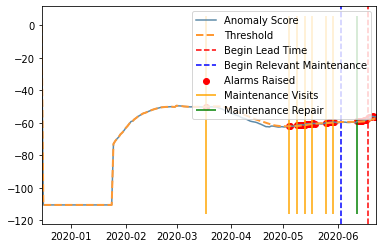

In [4]:
import matplotlib.pyplot as plt

benchmark = Benchmark()
evaluator = MaintenanceCostEvaluator(dataset_id='turbofan_engine')
detector = MultiModelHTMDetector(evaluator=evaluator)

turbofan_engine_dataset = benchmark.get_dataset('turbofan_engine')
rtf = turbofan_engine_dataset.get_rtf('FD001_1_0')
df_score = rtf.score(detector=detector)
detector.plot(df_score)
evaluation = evaluator.evaluate_rtf(df_score, plot=True)
plt.legend()
print(evaluation)